In [1]:
import os
import sys
import numpy as np
import scipy.sparse.csgraph
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import seaborn as sns
from collections import Counter
import itertools
plt.ion()
plt.show()

## Generate 4 clusters in 2D

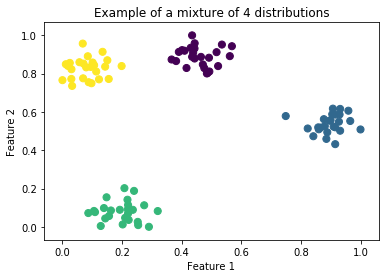

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

n_components = 4
data, truth = make_blobs(n_samples=100, centers=n_components, random_state=42, n_features=2)
data = preprocessing.MinMaxScaler().fit_transform(data)
plt.scatter(data[:, 0], data[:, 1], s=50, c = truth)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");


In [4]:
class DenseUnit1D:
    """
    This class 
    """
    def __init__(self, dimension, bin, minBin, maxBin, points):
        self.dimension = dimension # dimension index
        self.bin = bin # bin number
        self.minBin = minBin # inferior bin limit
        self.maxBin = maxBin # superior bin limit
        self.points = points # observation indexes in input data

    def distance(self, du):
        # Not in the same dimension, can't be neighbors
        if self.dimension != du.dimension:
            return -1
        return abs(self.bin -du.bin)
    
    def __eq__(self, other):
        """Overrides the default implementation"""
        if isinstance(other, DenseUnit):
            return (Counter(self.dimension) == Counter(other.dimension) and
                   Counter(self.points) == Counter(other.points) )
        return False
    
    def __hash__(self):
        return hash(str(self))
    
    def __str__(self):
        return (f'Dimension {self.dimension}, bin {self.bin}, points {len(self.points)},' +
    f'[{round(self.minBin, 2)}, {round(self.maxBin, 2)}]')



def neighbour(denseUnits1, denseUnits2):
    """
    Determines if 2 dense units are neighbouring
    """
    # We allow only 1 bin deviation in one subspace
    distance = 0
    for subspace in range(len(denseUnits1)):
        subspaceDistance = denseUnits1[subspace].distance(denseUnits2[subspace])
        if subspaceDistance == -1:
            return False
        distance += subspaceDistance
        if distance > 1:
            return 0
    return True


In [5]:
thresholdPoints = 2 # minimal number of points that must exist in a bin in order to be considered dense
nbBins = 8 # number of bins on each dimension

## Create one dimensionals dense units

In [7]:
def createDenseUnitsAndGrid(data, thresholdPoints = thresholdPoints, nbBins = nbBins):
    """
    This method will return an array of lists, each list containing 1D dense units
    In 1 D subspace, each list will contain only one element
    """
    denseUnits1D = []
    grid=[] # this is used for rendering purposes
    for curDim in range(data.shape[1]):
        minDim = min(data[:,curDim])
        maxDim = max(data[:,curDim])
        binSize = (maxDim - minDim)/nbBins
        points = data[:, curDim]
        g = [] # grid lines for current dimension
        g.append(minDim)
        for i in range(nbBins):
            endBin = minDim + binSize
            g.append(endBin)
            # Retrieve bin points per dimension
            if i == nbBins -1 : # last bin, make sure all points are included
                binPoints = np.where((points>=minDim) & (points<=maxDim))[0]
                endBin = maxDim
            else:
                binPoints = np.where((points>=minDim) & (points<endBin))[0]
            # Store only dense bins
            if len(binPoints)>thresholdPoints:
                denseUnits1D.append([DenseUnit1D(curDim, i,minDim,endBin,binPoints)])
            minDim = endBin
        grid.append(g)
    return denseUnits1D, grid

In [8]:
denseUnits1D, grid = createDenseUnitsAndGrid(data)

## Plot original dataset on the grid

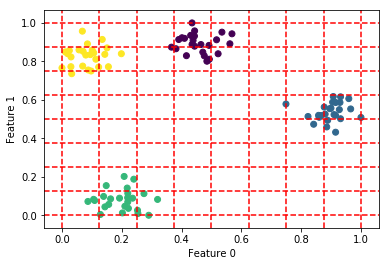

In [16]:
plt.scatter(data[:, 0], data[:, 1], c = truth)
for g in grid[0]:
    plt.axvline(x=g, c = 'red', linestyle ='--')
    plt.xlabel('Feature 0')
    
for g in grid[1]:
    plt.axhline(y=g, c = 'red', linestyle ='--')
    plt.ylabel('Feature 1')

## Find clusters in overlapping dense units

In [10]:
def denseBinsToClusters(candidates, plot = False, debug = False):
    """
    This method takes as input a collection of subspace candidates.
    A subspace candidate is a list of 1D dense units.
    This method will merge neighbouring units by projecting them onto a 
    graph, where we can easily compute connected components
    """
    graph = np.identity(len(candidates))
    for i in range(len(candidates)):
        for j in range(len(candidates)):
            graph[i, j] = int(neighbour(candidates[i], candidates[j]))
    # Find connected components in order to merge neighbouring bins
    nbConnectedComponents, components = scipy.sparse.csgraph.connected_components(
            graph, directed=False)
    if debug:
        print(graph)
        print(nbConnectedComponents, components)

    candidates = np.array(candidates)


    clusterAssignment = -1 * np.ones(data.shape[0])
    # For every cluster
    for i in range(nbConnectedComponents):
        # Get dense units of the cluster
        cluster_dense_units = candidates[np.where(components == i)[0]]
        if debug:
            for v in cluster_dense_units:
                for z in v:
                    print(z)
        clusterDimensions = {}
        for j in range(len(cluster_dense_units)):
            for k in range(len(cluster_dense_units[j])):
                if cluster_dense_units[j][k].dimension not in clusterDimensions:
                    clusterDimensions[cluster_dense_units[j][k].dimension] = []
                clusterDimensions[cluster_dense_units[j][k].dimension].extend(cluster_dense_units[j][k].points)

        points =reduce(np.intersect1d, list(clusterDimensions.values()))
        clusterAssignment[points] = i
        if plot:
            pred = -1 * np.ones(data.shape[0])
            pred[points] = i
            plt.figure()
            plt.title(f'In yellow, clusters in {list(clusterDimensions.keys())} dimensions ')
            plt.scatter(data[:, 0], data[:, 1], c = pred)
            for g in grid[0]:
                plt.axvline(x=g, c = 'red', linestyle ='--')

            for g in grid[1]:
                plt.axhline(y=g, c = 'red', linestyle ='--')
            plt.show()
        if debug:
            print(clusterDimensions.keys(), points)
    return clusterAssignment

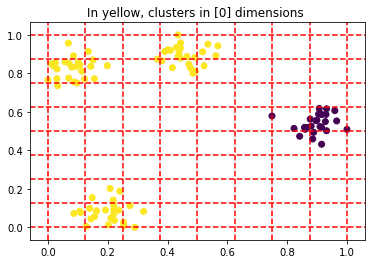

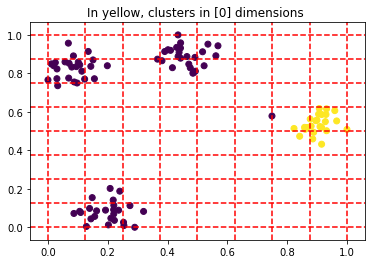

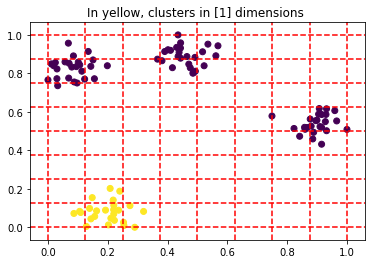

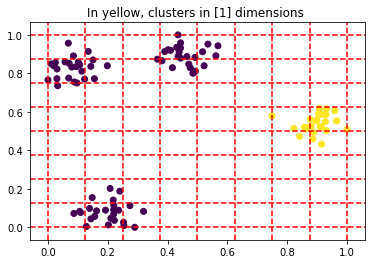

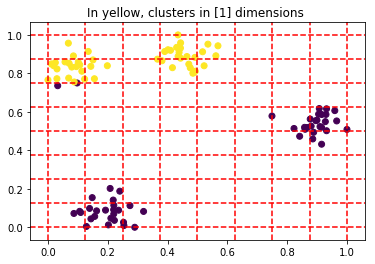

In [11]:
denseBinsToClusters(denseUnits1D, plot = True, debug = False);

## For k dimensional subspaces (k >=2), create dense unit candidates in kD

In [12]:
def getSubspaceCandidates(previousUnits, subspaceDimension = 2):
    import itertools
    candidates = []
    for ix1, ix2 in itertools.combinations(range(len(previousUnits)), 2):
        dims =[]
        candidate = []

        for i in range(len(previousUnits[ix1])):
            dims.append(previousUnits[ix1][i].dimension)
            candidate.append(previousUnits[ix1][i])
            points1= previousUnits[ix1][i].points

        for i in range(len(previousUnits[ix2])):
            dims.append(previousUnits[ix2][i].dimension)
            candidate.append(previousUnits[ix2][i])
            points2= previousUnits[ix2][i].points 
        points = np.intersect1d(points1, points2) # check points in common
        if np.unique(dims).shape[0] == subspaceDimension and points.shape[0]>thresholdPoints:
#             print(f'\n\nadding candidate: {len(points)}')
#             for v in candidate:
#                 print(v)
            candidates.append(candidate)
    return candidates

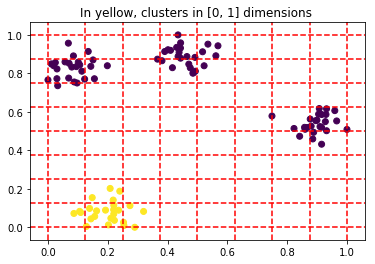

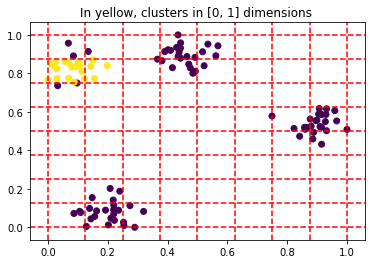

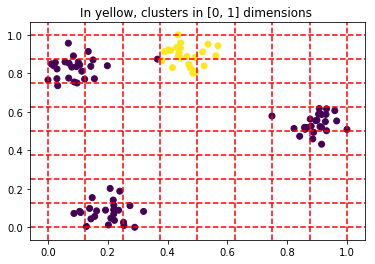

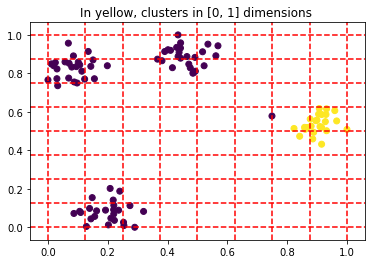

In [13]:
for subspaceDim in range(2, data.shape[1] +1):
    subspaceCandidates = getSubspaceCandidates(denseUnits1D, subspaceDimension = subspaceDim)
    pred = denseBinsToClusters(subspaceCandidates, plot = True, debug = False);

## Visualize final results

Purple points have been excluded from clustering because they are situated on sparse grid bins.

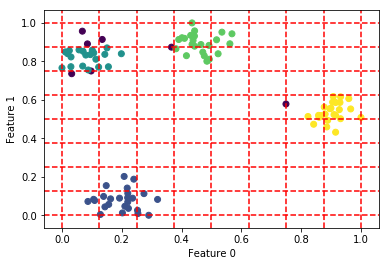

In [14]:
plt.scatter(data[:, 0], data[:, 1], c = pred)
for g in grid[0]:
    plt.axvline(x=g, c = 'red', linestyle ='--')
    plt.xlabel('Feature 0')
    
for g in grid[1]:
    plt.axhline(y=g, c = 'red', linestyle ='--')
    plt.ylabel('Feature 1')

## Validate results with adjusted rand index

In [15]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(truth, pred)

0.9090183974614624